In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/My\ Drive/data

femaleeyes  maleeyes


In [4]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Function is defined to split the images into data and labels with help of 
os.path.sep into a pair of head and tail.
Tuple is returned of data and labels which is used further

In [5]:
class SimpleDatasetLoader:
    # Method: Constructor
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    
    def load(self, image_paths, verbose=-1):
        
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))


In this code we are just resizing our image and shrinking the image, with the help of INTER_AREA interpolation
       

In [6]:
class SimplePreprocessor:
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.interpolation = interpolation

    
    def preprocess(self, image):
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

In [7]:
image_paths = list(paths.list_images("/content/gdrive/My Drive/data"))

In [8]:
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)

[INFO]: Processed 500/8998
[INFO]: Processed 1000/8998
[INFO]: Processed 1500/8998
[INFO]: Processed 2000/8998
[INFO]: Processed 2500/8998
[INFO]: Processed 3000/8998
[INFO]: Processed 3500/8998
[INFO]: Processed 4000/8998
[INFO]: Processed 4500/8998
[INFO]: Processed 5000/8998
[INFO]: Processed 5500/8998
[INFO]: Processed 6000/8998
[INFO]: Processed 6500/8998
[INFO]: Processed 7000/8998
[INFO]: Processed 7500/8998
[INFO]: Processed 8000/8998
[INFO]: Processed 8500/8998


In [9]:
data = data.reshape((data.shape[0], 3072))

In [10]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [11]:
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [12]:
print('Classification starting')
model = KNeighborsClassifier(n_neighbors=7,
                             n_jobs=1)
model.fit(train_x, train_y)
print(classification_report(test_y, model.predict(test_x),
                            target_names=le.classes_))

Classification starting
              precision    recall  f1-score   support

  femaleeyes       0.88      0.82      0.85      1308
    maleeyes       0.77      0.85      0.81       942

    accuracy                           0.83      2250
   macro avg       0.83      0.83      0.83      2250
weighted avg       0.84      0.83      0.83      2250



Our KNN classifier worked really well with accuracy of 83 %. But KNN took alot of time to train.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten

In [32]:
!pip install split_folders tqdm
!pip install seedir

In [33]:
import splitfolders #for easier dataset splitting  
import seedir as sd #for directory tree viewer

In [34]:
target_dir = '/content/gdrive/My Drive/data'

In [35]:
splitfolders.ratio(target_dir, 
                   output= './split_dataset',
                   seed=42, 
                   ratio=(0.8,0.2), 
                   group_prefix=None)

Copying files: 8998 files [00:21, 411.20 files/s]


In [36]:
train_set = './split_dataset/train'
val_set = './split_dataset/val'

In [37]:
from keras.preprocessing.image import ImageDataGenerator

In [38]:
train_aug = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    zoom_range=0.2,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

#only rescale the validation set, dont do the augmentation step for validation set, it might cause bias
valid_aug = ImageDataGenerator(rescale=1./255)

In [105]:
traingen = train_aug.flow_from_directory(
        train_set,  
        target_size=(60, 60),  
        batch_size=64,
        class_mode='binary')

validgen = valid_aug.flow_from_directory(
        val_set, 
        target_size=(60, 60), 
        batch_size=64, 
        class_mode='binary')

Found 7198 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.


In [109]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
from keras.layers import BatchNormalization

Did Many iterations with architectures and found with this architectures got highest accuracy even though CNN model perfromed very poorly among the 3 models . Only trained for less epoch due to computional resources. Surely increasing epoch will enhace the model performance.

In [131]:
model7 = Sequential()

#### Input Layer ####
model7.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(60, 60, 3),kernel_initializer="glorot_uniform"))

#### Convolutional Layers ####
model7.add(Conv2D(64, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))  # Pooling
model7.add(Dropout(0.4)) # Dropout

model7.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model7.add(Conv2D(128, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.4))

model7.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model7.add(Conv2D(128, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.4))

model7.add(Conv2D(256, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model7.add(Activation('relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.4))

#### Fully-Connected Layer ####
model7.add(Flatten())
model7.add(Dropout(0.4))
model7.add(Dense(1, activation='softmax'))

model7.summary() # a handy way to inspect the architecture

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 60, 60, 64)        1792      
                                                                 
 conv2d_35 (Conv2D)          (None, 58, 58, 64)        36928     
                                                                 
 batch_normalization_16 (Bat  (None, 58, 58, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 29, 29, 64)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 29, 29, 128)     

In [129]:
print(f"TF version: {tf.__version__}, Keras version: {keras.__version__}\n")

TF version: 2.7.0, Keras version: 2.7.0



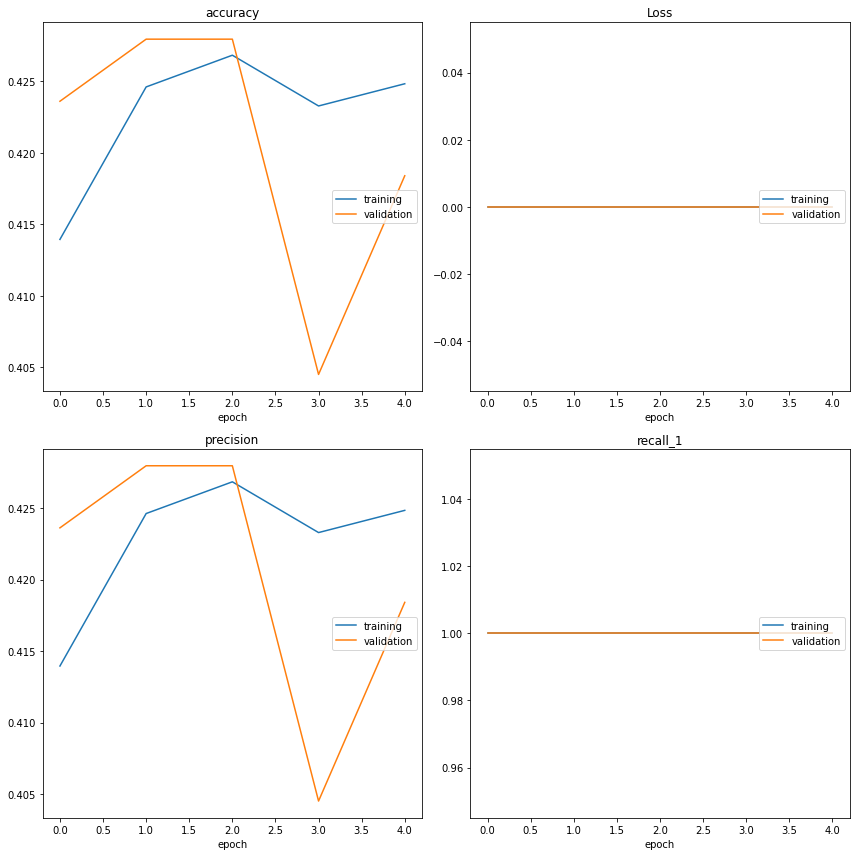

accuracy
	training         	 (min:    0.414, max:    0.427, cur:    0.425)
	validation       	 (min:    0.405, max:    0.428, cur:    0.418)
Loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
precision
	training         	 (min:    0.414, max:    0.427, cur:    0.425)
	validation       	 (min:    0.405, max:    0.428, cur:    0.418)
recall_1
	training         	 (min:    1.000, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
71/71 [==============================] - 261s 4s/step - loss: 0.0000e+00 - accuracy: 0.4248 - recall_1: 1.0000 - precision: 0.4248 - val_loss: 0.0000e+00 - val_accuracy: 0.4184 - val_recall_1: 1.0000 - val_precision: 0.4184


In [135]:
BATCH_SIZE = 100
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 5

optimizer = Adam(learning_rate=0.01)

model7.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model7.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=True)

In [136]:
train_x

array([[ 44,  32,  20, ...,  39,  29,  19],
       [ 19,  37,   8, ...,  45,  60,  30],
       [136, 107,  76, ...,  94,  64,  29],
       ...,
       [236, 225, 206, ..., 169, 144,  94],
       [112,  90,  53, ...,  98,  78,  31],
       [137, 101,  61, ...,  81,  67,  18]], dtype=uint8)

In [137]:
train_x = train_x*255

In [138]:
test_x = test_x/255

ReLu is the best and most advanced activation function that why used.
Dropouts are used to safeguard model from overfitting

In [145]:

modelMLP = Sequential()
modelMLP.add(Flatten(input_shape=train_x.shape[1:]))
modelMLP.add(Dense(1000, activation="relu"))
modelMLP.add(Dropout(0.2))
modelMLP.add(Dense(512, activation="relu"))
modelMLP.add(Dropout(0.2))
modelMLP.add(Dense(1,activation="softmax"))
    
    # Compile the model
modelMLP.compile(loss="categorical_crossentropy", optimizer="rmsprop", 
                  metrics=["accuracy"])


In [146]:
modelMLP.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [147]:
history = modelMLP.fit(train_x, train_y,
          batch_size=32, epochs=10,
          validation_data=(test_x, test_y))

Epoch 1/10
211/211 [==============================] - 9s 36ms/step - loss: 42.9645 - accuracy: 0.4235 - recall_2: 1.0000 - precision_1: 0.4235 - val_loss: 0.6913 - val_accuracy: 0.4187 - val_recall_2: 1.0000 - val_precision_1: 0.4187
Epoch 2/10
211/211 [==============================] - 7s 35ms/step - loss: 0.7897 - accuracy: 0.4235 - recall_2: 1.0000 - precision_1: 0.4235 - val_loss: 0.6847 - val_accuracy: 0.4187 - val_recall_2: 1.0000 - val_precision_1: 0.4187
Epoch 3/10
211/211 [==============================] - 7s 35ms/step - loss: 0.7522 - accuracy: 0.4235 - recall_2: 1.0000 - precision_1: 0.4235 - val_loss: 0.6819 - val_accuracy: 0.4187 - val_recall_2: 1.0000 - val_precision_1: 0.4187
Epoch 4/10
211/211 [==============================] - 7s 35ms/step - loss: 0.6828 - accuracy: 0.4235 - recall_2: 1.0000 - precision_1: 0.4235 - val_loss: 0.6808 - val_accuracy: 0.4187 - val_recall_2: 1.0000 - val_precision_1: 0.4187
Epoch 5/10
211/211 [==============================] - 7s 35ms/step 

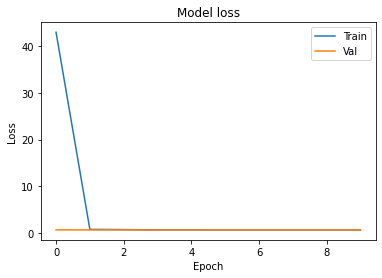

In [148]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

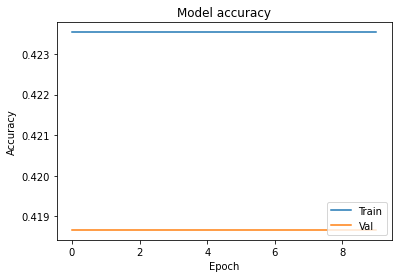

In [149]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

MLP has somewhat same accuracy as CNN. One raeson is of low epoch training. Time consumption was very low among 3 models.

Conclusion:-
1. Surprisingly, KNN performed better among 3 models
2. Changing optimisers and adding more layers could help MLP and CNN
3. Will do iterations on regularizations also to see effect.
4. KNN took alot time as compare to CNN and MLP